In [554]:
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
#plt.style.use('seaborn-poster')

#filename and folder to plot
fname= "walking_1"
folder = "hw2data/train/"

vals = np.load(folder+fname+".npy")
xyz = np.reshape( vals[:,:], (38,3,-1) )


print(xyz.shape)

#define the root joint and scaling of the values
r = 1000
xroot, yroot, zroot = xyz[0,0,0], xyz[0,0,1], xyz[0,0,2]

#define the connections between the joints (skeleton) 
I = np.array(
        [1, 2, 3, 4, 5, 6, 1, 8, 9, 10, 11, 12, 1, 14, 15, 16, 17, 18, 19, 16, 21, 22, 23, 25, 26, 24, 28, 16, 30, 31,
         32, 33, 34, 35, 33, 37]) - 1
J = np.array(
        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32,
         33, 34, 35, 36, 37, 38]) - 1


(38, 3, 100)


In [555]:
# plot the skeleton accroding to joints (each plot is png image in anim folder)

for tind in range(1,xyz.shape[2]):
    
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    for ijind in range(0,I.shape[0]):
        xline = np.array([xyz[I[ijind],0,tind], xyz[J[ijind],0,tind]])
        yline = np.array([xyz[I[ijind],1,tind], xyz[J[ijind],1,tind]])
        zline = np.array([xyz[I[ijind],2,tind], xyz[J[ijind],2,tind]])
        # use plot if you'd like to plot skeleton with lines
        ax.plot(xline,yline,zline)
    
    # use scatter if you'd like to plot all points without lines 
    # ax.scatter(xyz[:,0,tind],xyz[:,1,tind],xyz[:,2,tind], c = 'r', s = 50)   

    ax.set_xlim([-r+xroot, r+xroot])
    ax.set_zlim([-r+zroot, r+zroot])
    ax.set_ylim([-r+yroot, r+yroot])
    
    plt.savefig('anim/'+f"{tind}.png")
    plt.close()

# when plotting a single sample (the skeleton can simply be plotted without saving an image)
#     plt.draw()
#     plt.pause(.001)
#     plt.show()

 
    
# save the animated plot as a gif in anim folder 
from PIL import Image

images = [Image.open('anim/'+f"{n}.png") for n in range(1,xyz.shape[2])]
images[0].save('anim/'+fname+'.gif', save_all=True, append_images=images[1:], duration=30, loop=0) 

# remove ploted png images
for n in range(1,xyz.shape[2]):
    os.remove('anim/'+f"{n}.png")

## Task 1
Compile all the train samples into a matrix 𝑋𝑡𝑟𝑎𝑖𝑛 and apply PCA such that PCA modes are spatial
modes and coefficients are time-dependent coefficients. Investigate how many PCA spatial modes you
need to keep to approximate 𝑋𝑡𝑟𝑎𝑖𝑛 up to 70%, 80% , 90% , 95% in Frobenius norm (i.e., energy). Plot
the cumulative energy to justify your results

In [556]:
# create matrix X_train

#empty list to store the 15 samples
samples = []

# File paths and sample names for 15 samples (5 samples per movement type)
folder = "hw2data/train/"
movements = ['walking', 'running', 'jumping']

# Load each sample
for movement in movements:
    for i in range(1, 6):  # 5 samples for each movement
        fname = f"{movement}_{i}.npy"
        sample = np.load(folder + fname)
        samples.append(sample)

X_train = np.hstack(samples)

In [528]:
# # make xtrain!!

# # organize the samples by movement type
# walking_samples = samples[:5]  # First 5 samples - walking
# running_samples = samples[5:10]  # Next 5 samples - running
# jumping_samples = samples[10:]  # Last 5 samples - jumping

# # Stack the walking, running, and jumping samples together
# X_train_walking = np.stack(walking_samples, axis=-1)  # shape (114, 100, 5)
# X_train_running = np.stack(running_samples, axis=-1)  
# X_train_jumping = np.stack(jumping_samples, axis=-1)  

# # Reshape each movement block to (114, 500)
# X_train_walking_reshaped = X_train_walking.reshape(114, -1)  # Shape: (114, 500)
# X_train_running_reshaped = X_train_running.reshape(114, -1) 
# X_train_jumping_reshaped = X_train_jumping.reshape(114, -1)  


# # concatenate reshaped blocks along the columns
# X_train = np.concatenate([X_train_walking_reshaped, X_train_running_reshaped, X_train_jumping_reshaped], axis=1)


# print(X_train.shape) 



### PCA

In [557]:
from sklearn.decomposition import PCA

# apply PCA to X_train
pca = PCA()
X_train_pca = pca.fit_transform(X_train.T)

# X_train_pca has principal components 
print("Shape of X_train_pca:", X_train_pca.shape)

#singular values - variances in each direction - maybe time dependent coeffs?
sing = pca.singular_values_

#find the full Frobenius norm (energy) - using all 114 PCA spatial modes
fullnorm = np.sqrt(np.sum(sing**2))
print(fullnorm)


Shape of X_train_pca: (1500, 114)
43215.89245911891


[68.80121582479744, 85.24018928475724, 91.0751303706974, 93.87250708058197, 95.5401390403948]


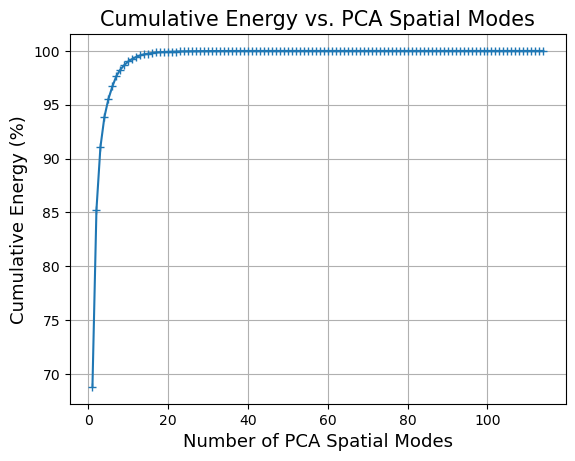

In [558]:
# PCA for different numbers of spatial modes

energies = []

for j in np.arange(1,114+1):
    pca = PCA(n_components=j)
    X_train_pca = pca.fit_transform(X_train.T)
    s = pca.singular_values_
    norm = np.sqrt(np.sum(s**2))
    energy = (norm/fullnorm) * 100
    energies.append(energy)

# number of PCA spatial modes required to approximate X_train up to 70%, 80% , 90% , 95%
print(energies[:5])
mode_70 = energies[1] # 2 required for 70%
mode_80 = energies[1] # 2 required for 80%
mode_90 = energies[2] # 3 required for 90%
mode_95 = energies[4] # 5 required for 95%

# plot the cumulative energy as a function of number of PCA spatial modes
plt.plot(np.arange(1,114+1),energies, marker='+')
plt.xlabel('Number of PCA Spatial Modes', fontsize=13)
plt.ylabel('Cumulative Energy (%)', fontsize=13)
plt.title('Cumulative Energy vs. PCA Spatial Modes', fontsize=15)
plt.grid(True)

## Task 2
Truncate the PCA modes set to 2 and 3 modes and plot the projected 𝑋𝑡𝑟𝑎𝑖𝑛 in the truncated PCA
space as low dimensional 2D (PC1,PC2 coordinates) and 3D (PC1,PC2,PC3 coordinates) trajectories.
Use colors for different movements and discuss visualization and your findings.

In [559]:
#pca with 2 components/spatial modes
pca_2 = PCA(n_components=2)

# fit transform
X_train_pca_2 = pca_2.fit_transform(X_train.T)  # Project data into 2D PCA space

# should have 2 and 3 columns respectively 
print("Shape of X_train_pca_2:", X_train_pca_2.shape)

Shape of X_train_pca_2: (1500, 2)


### 2D Plot

/var/folders/7z/vlh_zbvn2hn1c18j5t89jkh40000gp/T/ipykernel_17555/744678348.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)


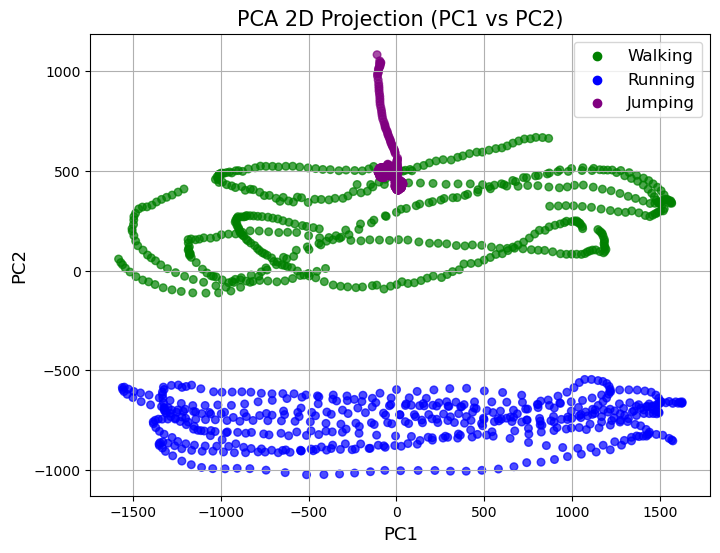

In [560]:
# make walking, running, jumping [green, blue, purple] resp.
colors = np.array(["g"] * 500 + ["b"] * 500 + ["purple"] * 500)  # 500 walking, 500 running, 500 jumping 

# scatter plot for 2D PCA projection (PC1 vs PC2)
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca_2[:, 0], X_train_pca_2[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)

# make a legend by making empty scatter plots for each movement type
plt.scatter([], [], color="g", label="Walking")  
plt.scatter([], [], color="b", label="Running")  
plt.scatter([], [], color="purple", label="Jumping")  

plt.xlabel('PC1',fontsize=13)
plt.ylabel('PC2',fontsize=13)
plt.title('PCA 2D Projection (PC1 vs PC2)', fontsize=15)

plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### 3D Plot

Shape of X_train_pca_3: (1500, 3)


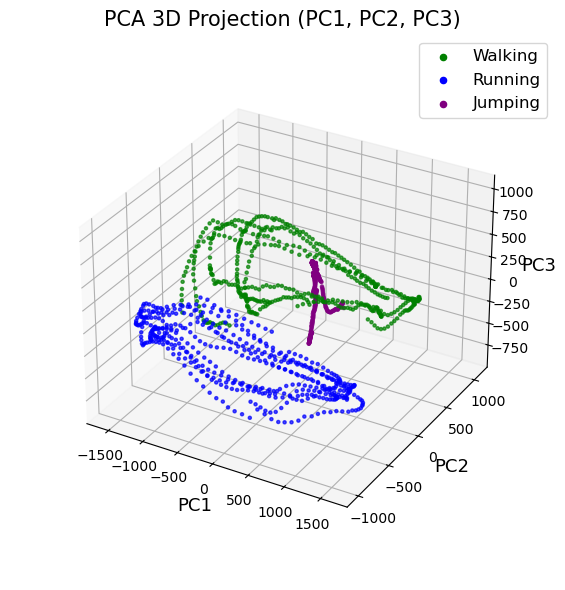

In [561]:
from mpl_toolkits.mplot3d import Axes3D

#pca with 3 components/spatial modes
pca_3 = PCA(n_components=3)

X_train_pca_3 = pca_3.fit_transform(X_train.T)  # Project data into 3D PCA space

print("Shape of X_train_pca_3:", X_train_pca_3.shape)

# making a 3D scatter plot
figure = plt.figure(figsize=(8, 6))  

#set up a 3D axis
ax = figure.add_subplot(1,1,1, projection='3d')  

# Scatter plot for 3D PCA projection (PC1, PC2, PC3)
scatter = ax.scatter(X_train_pca_3[:, 0], X_train_pca_3[:, 1], X_train_pca_3[:, 2], c=colors, s=5, alpha=0.7)

# Make a legend by creating empty scatter plots for each movement type
ax.scatter([], [], [], color="g", label="Walking")
ax.scatter([], [], [], color="b", label="Running")
ax.scatter([], [], [], color="purple", label="Jumping")

ax.set_xlabel('PC1', fontsize=13)
ax.set_ylabel('PC2', fontsize=13)
ax.set_zlabel('PC3', fontsize=13)
ax.set_title('PCA 3D Projection (PC1, PC2, PC3)', fontsize=15)

ax.legend(fontsize=12)
ax.grid(True)

ax.set_box_aspect(None, zoom=0.85)
plt.tight_layout()
plt.show()

## Task 3
In order to classify each sample with type of movement establish the following ground truth. Create a
vector of ground truth labels with an integer per class, and
assign an appropriate label to each sample in 𝑋𝑡𝑟𝑎𝑖𝑛. Then for each movement compute its centroid
(mean) in 𝑘-modes PCA space

In [562]:
# ground truth labels
# 0 = walking, 1 = running, 2 = jumping
#truth_labels = np.concatenate([np.zeros(5), np.ones(5), np.full(5, 2)])
truth_labels = np.concatenate([np.zeros(500), np.ones(500), np.full(500, 2)]) # [[0]*500 + [1]*500 + [2]*500]

#pca with 3 components/spatial modes
pca_3 = PCA(n_components=3)
X_train_pca_3 = pca_3.fit_transform(X_train.T)  # Project data into 3D PCA space

reshaped_pca3 = X_train_pca_3.reshape(15,100,3)

# dictionary to assign each coordinate point to a motion
#truths = {'Walking': reshaped_pca3[0:5], 'Running': reshaped_pca3[5:10],'Jumping': reshaped_pca3[10:15]}
truths = {'Walking': X_train_pca_3[0:500], 'Running': X_train_pca_3[500:1000],'Jumping': X_train_pca_3[1000:1500]}

#print(truths)

print(reshaped_pca3.shape)

print(truths['Running'].shape)

#dictionary.update({'key': value})


(15, 100, 3)
(500, 3)


In [563]:
#find the centroids

# walk_centroid = [np.mean(truths['Walking'][:,:,0]), np.mean(truths['Walking'][:,:,1]), np.mean(truths['Walking'][:,:,2])]
# run_centroid = [np.mean(truths['Running'][:,:,0]), np.mean(truths['Running'][:,:,1]), np.mean(truths['Running'][:,:,2])]
# jump_centroid = [np.mean(truths['Jumping'][:,:,0]), np.mean(truths['Jumping'][:,:,1]), np.mean(truths['Jumping'][:,:,2])]

walk_centroid = np.mean(truths['Walking'], axis=0)#, np.mean(truths['Walking']), np.mean(truths['Walking'])]
run_centroid = np.mean(truths['Running'], axis =0)#, np.mean(truths['Running']), np.mean(truths['Running'])]
jump_centroid = np.mean(truths['Jumping'], axis=0)#, np.mean(truths['Jumping']), np.mean(truths['Jumping'])]

print(walk_centroid)
print(run_centroid)
print(jump_centroid)

[-36.88211143 253.35282541 175.91202104]
[  60.77197779 -752.7210869  -103.41194553]
[-23.88986635 499.36826149 -72.5000755 ]


## Task 4
Having the ground truth, preform the following training. Create another vector of trained labels. To
assign these labels, for each sample in 𝑋𝑡𝑟𝑎𝑖𝑛 compute the distance between the projected point in
𝑘-modes PCA space and each of the centroids. The minimal distance will determine to which class
the sample belongs. Assign the label of the class of the centroid with minimal distance in the trained
labels vector. Compute the trained labels for various 𝑘 values of 𝑘-PCA truncation and report the
accuracy of the trained classifier (the percentage of samples for which the ground truth and the trained
labels match). You can use accuracy_score function in 𝑠𝑘𝑙𝑒𝑎𝑟𝑛 for this purpose. Discuss your results
in terms of optimal 𝑘 for the classifier accuracy

In [564]:
from sklearn.metrics import accuracy_score
from scipy import linalg

distances = np.zeros((1500,3))
#distances = np.zeros((15,3)) 

for j in range(1500):
    distances[j,:] = [np.linalg.norm(X_train_pca_3[j,:] - walk_centroid), 
                      np.linalg.norm(X_train_pca_3[j,:] - run_centroid),
                      np.linalg.norm(X_train_pca_3[j,:] - jump_centroid)]
    
# for j in range(1500):
#     distances[j,:] = [np.linalg.norm(reshaped_pca3[j,:] - walk_centroid), 
#                       np.linalg.norm(reshaped_pca3[j,:] - run_centroid),
#                       np.linalg.norm(reshaped_pca3[j,:] - jump_centroid)]
    
trained_labels = np.argmin(distances, axis=1)

print(trained_labels)
print("shape of trained_labels:", trained_labels.shape)

print(truth_labels)
#print("shape of truth_labels:", truth_labels.shape)

#accuracy score of the trained labels
print("Accuracy score of 3PCA modes case:", accuracy_score(truth_labels, trained_labels))


[0 0 0 ... 2 2 2]
shape of trained_labels: (1500,)
[0. 0. 0. ... 2. 2. 2.]
Accuracy score of 3PCA modes case: 0.756


[0.         0.50733333 0.88133333 0.756      0.73       0.75066667
 0.726      0.87066667 0.87533333 0.87866667 0.888      0.908
 0.90933333 0.91       0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667
 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667 0.91066667


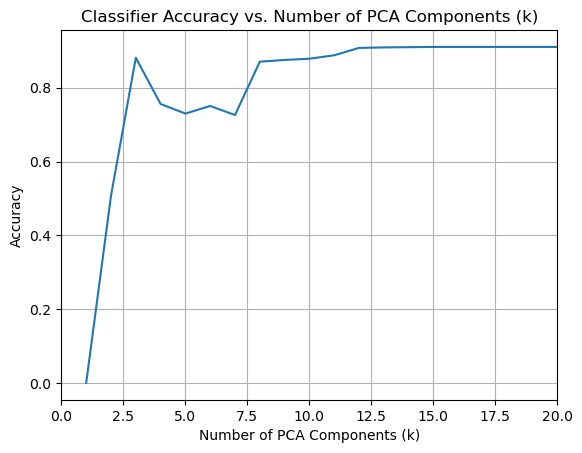

In [565]:
## ROW BY ROW WAY
# 
# 
# # repeat for any possible k-value up to 114
dist_k = np.zeros((1500,3))
accuracy = np.zeros(114)

for k in range(1,114):
    pca_k = PCA(n_components=k)
    Xtr = pca_k.fit_transform(X_train.T)

    reshaped_pca_k = Xtr.reshape(15,100,k)

    #finding centroids for walk, run, jump in this particular k-space
    cen_walk = np.mean(Xtr[0:500], axis=0)
    cen_run = np.mean(Xtr[500:1000], axis=0)
    cen_jump = np.mean(Xtr[1000:1500], axis=0)
    
    #find the distances from the centroids
    for j in range(1500):
        dist_k[j,:] = [np.linalg.norm(Xtr[j,:] - cen_walk), 
                     np.linalg.norm(Xtr[j,:] - cen_run),
                     np.linalg.norm(Xtr[j,:] - cen_jump)]
    
    #find the closest centroid (and therefore assign the movement type)
    trained_labels_k = np.argmin(dist_k, axis=1)

    accuracy[k] = accuracy_score(truth_labels, trained_labels_k)

print(accuracy)

plt.plot(np.arange(1, 115), accuracy)
plt.xlabel("Number of PCA Components (k)")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy vs. Number of PCA Components (k)")
plt.grid(True)
plt.xlim([0,20]) #can extend this out, it stays at 1
plt.show()


## Task 5

To test how the classification performs on classification/recognition of new samples, load the given test
samples and for each test sample assign the ground truth label. By projecting onto 𝑘-PCA space and
computing the distance to the centroids, predict the test labels. Report the accuracy of the classifier
on the test samples. Discuss and compare it with trained accuracy. Try various 𝑘 values.

In [566]:
# load the test data 
# create matrix X_train

#empty list to store the 15 samples
test_samples = []

# File paths and sample names for 15 samples (5 samples per movement type)
folder = "hw2data/test/"
movements = ['walking', 'running', 'jumping']

# Load each sample
for movement in movements:
    fname = f"{movement}_1t.npy"
    test_sample = np.load(folder + fname)
    test_samples.append(test_sample)

X_test = np.hstack(test_samples)

In [567]:
# apply PCA to X_test
pca = PCA()
X_test_pca = pca.fit_transform(X_test.T) #apparently only use transform not fit.transform

# X_test_pca has principal components 
print("Shape of X_test_pca:", X_test_pca.shape)

Shape of X_test_pca: (300, 114)


[0.         0.48666667 0.98333333 0.92333333 0.74666667 0.91666667
 0.71666667 0.94333333 0.93       0.94333333 0.94333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333
 0.95333333 0.95333333 0.95333333 0.95333333 0.95333333 0.9533

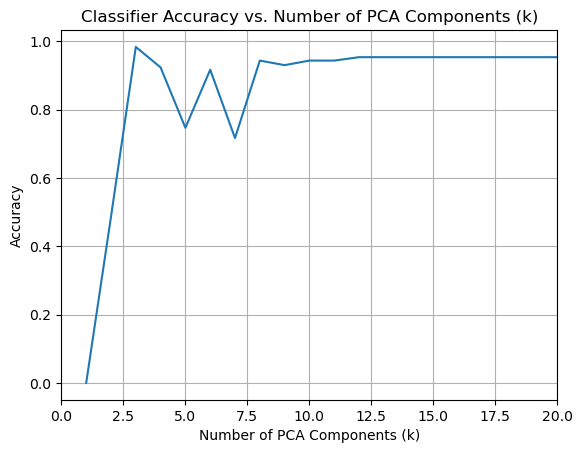

In [568]:
### NEW WAY

truth_labels_k = np.concatenate([np.zeros(100), np.ones(100), np.full(100, 2)])

test_dist_k = np.zeros((300,3))
test_accuracy = np.zeros(114)

for k in range(1,114):
    pca_k = PCA(n_components=k)
    Xtr = pca_k.fit_transform(X_train.T)

    #reshaped_pca_k = Xtr.reshape(15,100,k)

    #finding centroids for walk, run, jump in this particular k-space
    cen_walk = np.mean(Xtr[0:500], axis=0)
    cen_run = np.mean(Xtr[500:1000], axis=0)
    cen_jump = np.mean(Xtr[1000:1500], axis=0)
    
   
    pca_test = pca_k.transform(X_test.T)

    #find the distances from the centroids
    for j in range(300):
        test_dist_k[j,:] = [np.linalg.norm(pca_test[j,:] - cen_walk), 
                            np.linalg.norm(pca_test[j,:] - cen_run),
                            np.linalg.norm(pca_test[j,:] - cen_jump)]

    #find the closest centroid (and therefore assign the movement type)
    test_labels_k = np.argmin(test_dist_k,axis=1) 
    #print(test_labels_k)
    #print(test_labels_k.shape)

    test_accuracy[k] = accuracy_score(truth_labels_k, test_labels_k)

print(test_accuracy)

plt.plot(np.arange(1, 115), test_accuracy)
plt.xlabel("Number of PCA Components (k)")
plt.ylabel("Accuracy")
plt.title("Classifier Accuracy vs. Number of PCA Components (k)")
plt.grid(True)
plt.xlim([0,20]) #can extend this out, it stays at 1
plt.show()

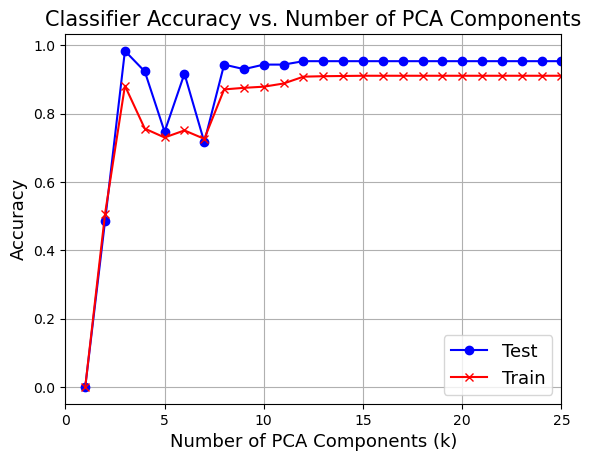

In [569]:
# Test accuracy
plt.plot(np.arange(1, 115), test_accuracy, label="Test", color="blue", marker="o")

# Training Accuracy
plt.plot(np.arange(1, 115), accuracy, label="Train", color="red", marker="x")

plt.xlabel("Number of PCA Components (k)", fontsize=13)
plt.ylabel("Accuracy", fontsize=13)
plt.title("Classifier Accuracy vs. Number of PCA Components", fontsize=15)
plt.legend(fontsize=13)
plt.xlim([0,25])
plt.grid(True)
plt.show()

/var/folders/7z/vlh_zbvn2hn1c18j5t89jkh40000gp/T/ipykernel_17555/3485595407.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_test[:, 0], pca_test[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)


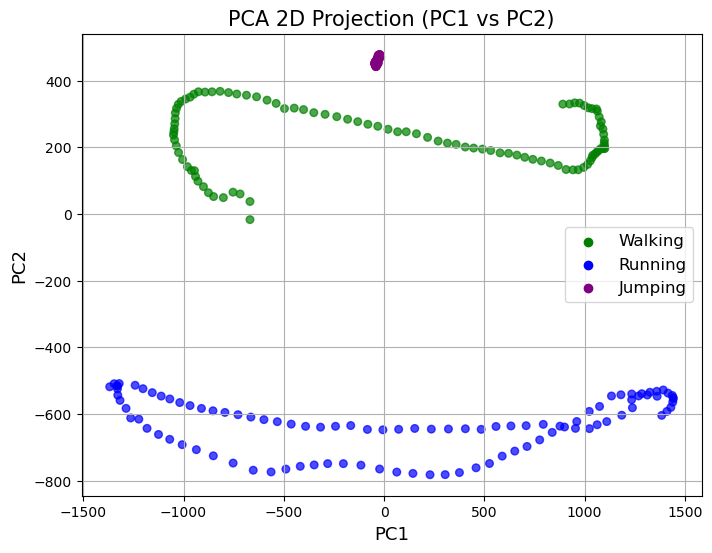

In [570]:
# make walking, running, jumping [green, blue, purple] resp.
colors = np.array(["g"] * 100 + ["b"] * 100 + ["purple"] * 100)  # 500 walking, 500 running, 500 jumping 

# scatter plot for 2D PCA projection (PC1 vs PC2)
plt.figure(figsize=(8, 6))
plt.scatter(pca_test[:, 0], pca_test[:, 1], c=colors, cmap='viridis', s=30, alpha=0.7)

# make a legend by making empty scatter plots for each movement type
plt.scatter([], [], color="g", label="Walking")  
plt.scatter([], [], color="b", label="Running")  
plt.scatter([], [], color="purple", label="Jumping")  

plt.xlabel('PC1',fontsize=13)
plt.ylabel('PC2',fontsize=13)
plt.title('PCA 2D Projection (PC1 vs PC2)', fontsize=15)

plt.legend(fontsize=12)
plt.grid(True)
plt.show()